<a href="https://colab.research.google.com/github/GaikwadSandesh/Book_Recommendation_System/blob/main/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import random 
import math

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Load data and Clean

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#Loading Datasets 
books=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Alma_better/Book Recommender system/Books.csv" )
ratings=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Alma_better/Book Recommender system/Ratings.csv")
users=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Alma_better/Book Recommender system/Users.csv")

## Handle Nan

### Books

In [11]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [12]:
books = books[books['ISBN'].apply(lambda x: str(x).isdigit())]

In [13]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [14]:
# we won't be using any image processing s we will drop image related columns

books.drop(columns = ['Image-URL-S' , 'Image-URL-M' , 'Image-URL-L'] , inplace =True)

In [15]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [16]:
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1995, 1982, 1985, 1992, 1986, 1978, 1980, 1983, 1952,
       1987, 1981, 1990, 1989, 1984, 0, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1972, 1960, 1979, 1966,
       1920, 1973, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1950,
       1967, 2005, 1957, 1937, 1955, 1954, 1946, 1930, 2011, 1925, 1948,
       1943, 1947, 1923, 1939, 1926, 1938, 2030, 1940, 1911, 1949, 1932,
       1928, 1929, 1945, 1927, 1936, 1931, 1914, 2050, 1934, 1910, 1933,
       1902, 1924, 1921, 2038, 2026, 1944, 1917, 1901, 2010, 1908, 1906,
       1935, 1806, 2021, '2000', '1995', '1999', '2003', '1990', '1994',
       '1986', '1989', '2002', '1981', '1993', '1983', '1982', '1976',
       '1991', '1977', '1998', '1992', '0', '2001', '1997', '1996',
       '2004', '1968', '1987', '1984', '1988', '1963', '1956', '1974',
       '1970', '1985', '1978', '1973', '1980', '1979', '1961', 

In [17]:
#investigating the rows having 'DK Publishing Inc' as yearOfPublication
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [18]:
#From above, it is seen that bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '0789466953','Book-Author'] = "James Buckley"
books.loc[books.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"
#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [19]:
#investigating the rows having 'DK Publishing Inc' as yearOfPublication
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [20]:
#making required corrections as above, keeping other fields intact
books.loc[books.ISBN == '2070426769','Year-Of-Publication'] = 2003
books.loc[books.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave"
books.loc[books.ISBN == '2070426769','Publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"

In [21]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [22]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249026 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 249026 non-null  object
 1   Book-Title           249026 non-null  object
 2   Book-Author          249025 non-null  object
 3   Year-Of-Publication  249026 non-null  int64 
 4   Publisher            249025 non-null  object
dtypes: int64(1), object(4)
memory usage: 11.4+ MB


In [23]:
#However, the value 0 is invalid and as this dataset was published in 2004, I have assumed the the years after 2006 to be 
#invalid keeping some margin in case dataset was updated thereafer
#setting invalid years as NaN
books.loc[(books['Year-Of-Publication']> 2006) | (books['Year-Of-Publication']==0 ),'Year-Of-Publication'] = np.NAN

In [24]:
books['Year-Of-Publication'].fillna(int(books['Year-Of-Publication'].median()) , inplace = True) 

In [25]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [26]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              1
dtype: int64

In [27]:
#exploring 'publisher' column
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [28]:
#  we will google and replace missing value
books.loc[187689,'Book-Author'] = 'David Tait'

In [29]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [30]:
#  we will google and replace missing value
books.loc[128890,'Publisher'] = 'Mundania Press LLC'
books.loc[129037,'Publisher'] = 'Simon & Schuster.'

In [31]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249027 entries, 0 to 128890
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 249026 non-null  object 
 1   Book-Title           249026 non-null  object 
 2   Book-Author          249026 non-null  object 
 3   Year-Of-Publication  249026 non-null  float64
 4   Publisher            249027 non-null  object 
dtypes: float64(1), object(4)
memory usage: 19.5+ MB


In [32]:
books.isnull().sum()

ISBN                   1
Book-Title             1
Book-Author            1
Year-Of-Publication    1
Publisher              0
dtype: int64

### Rating

In [33]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [34]:
# check for null values
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

## User

In [35]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [36]:
# Percentage of missing value
users.isnull().sum()/len(users)*100

User-ID      0.000000
Location     0.000000
Age         39.719857
dtype: float64

In [37]:
# Number of unique values
users.Location.nunique()

57339

we can use Location to do the clustring based of location and recommend the books y popularity but in this case we will not use location

In [38]:
# we won't be using any model with locations
users.drop('Location',axis=1,inplace=True)

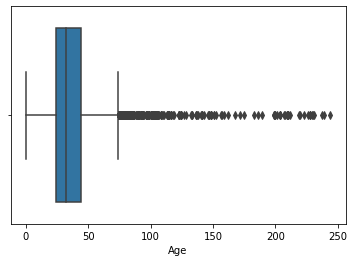

In [39]:
# check for outliers and medians
sns.boxplot(x = users.Age)

In [40]:
# outlier data became NaN
users.loc[(users.Age > 95) | (users.Age < 10), 'Age'] = np.nan

In [41]:
users.isna().sum()

User-ID         0
Age        112216
dtype: int64

In [42]:
# the data is skewd we can use median to fill the na values
users['Age'].fillna(users.Age.median(),inplace=True) 

In [43]:
users.isna().sum()

User-ID    0
Age        0
dtype: int64

# EDA

## Books

### Top Authors

Text(0.5, 1.0, 'Top 10 Authors')

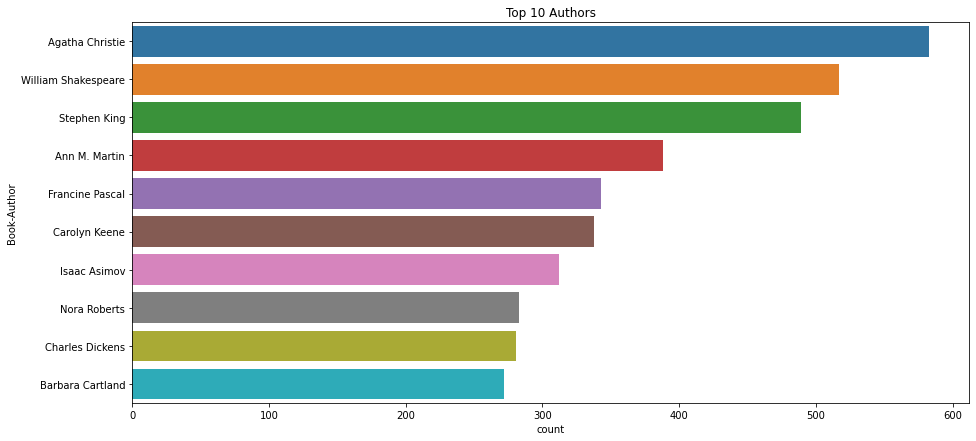

In [44]:
# lets plot the aithors with most books
plt.figure(figsize=(15,7))
sns.countplot(y='Book-Author',data=books,order=pd.value_counts(books['Book-Author']).iloc[:10].index)
plt.title('Top 10 Authors')

### Top Publishers

Text(0.5, 1.0, 'Top 10 Publishers')

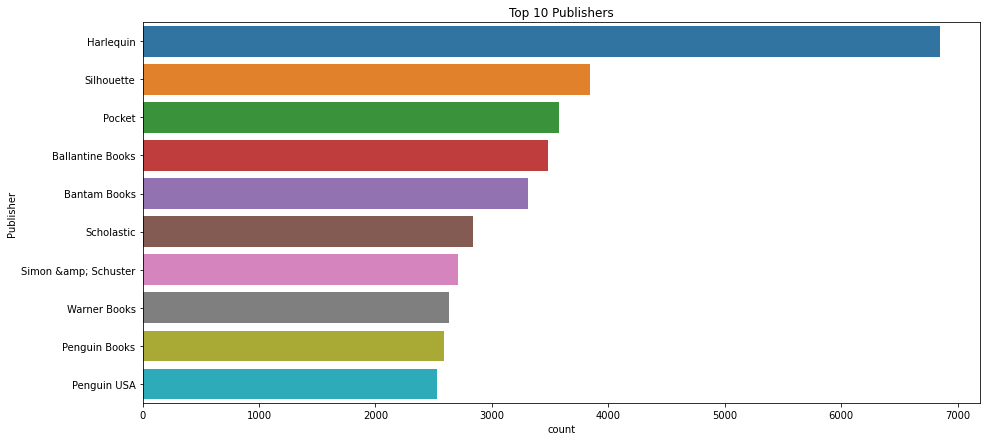

In [45]:
# let's check the publishers with most books
plt.figure(figsize=(15,7))
sns.countplot(y='Publisher',data=books,order=pd.value_counts(books['Publisher']).iloc[:10].index)
plt.title('Top 10 Publishers')

## Ratings

In [46]:
ratings.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [47]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [48]:
# let's check if there are any outliers
ratings['Book-Rating'].nunique()

11

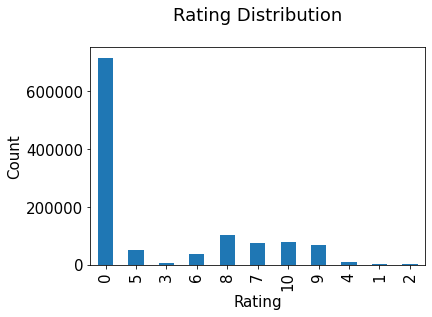

In [49]:
plt.rc("font", size=15)
ratings['Book-Rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [50]:
#Hence segragating implicit and explict ratings datasets
ratings_nonzero = ratings[ratings['Book-Rating'] != 0]
ratings_zero    = ratings[ratings['Book-Rating'] == 0]

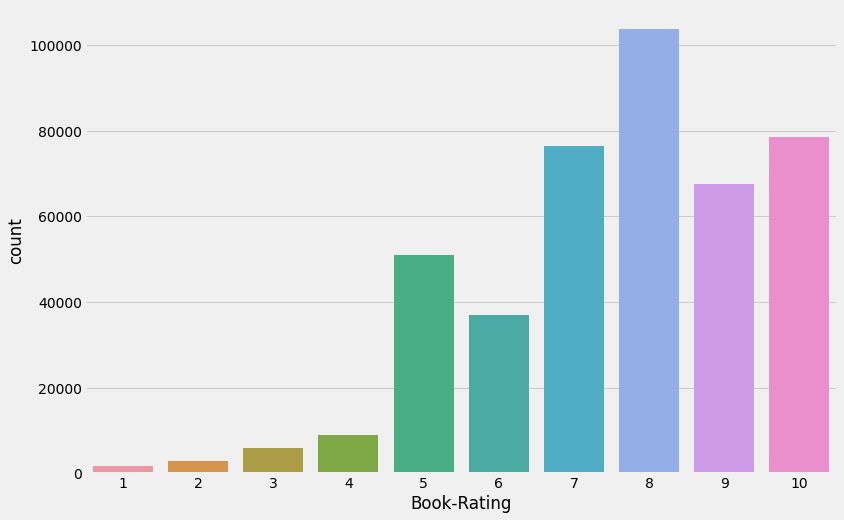

In [51]:
# we will plot the only explicit rating
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings_nonzero , x='Book-Rating')

####  Total  Ratings and avg nuber of ratings

In [52]:
# Create column Rating average 
ratings_nonzero['Avg_Rating'] = ratings_nonzero.groupby('ISBN')['Book-Rating'].transform('mean')
# Create column Rating sum
ratings_nonzero['Total_No_Of_Users_Rated']= ratings_nonzero.groupby('ISBN')['Book-Rating'].transform('count')

# Merge all datasets

In [53]:
# copy the users dataset
df=users.copy()
# merge ratings and users dataset on userid column
df=pd.merge(df,ratings_nonzero,on='User-ID')
# merge the previous data with isbn column
df=pd.merge(df,books,on='ISBN')

In [54]:
df.head()

,User-ID,Age,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,8,32.0,0002005018,5,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
1,11676,32.0,0002005018,8,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,67544,30.0,0002005018,8,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
3,116866,32.0,0002005018,9,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
4,123629,32.0,0002005018,9,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada


In [55]:
df = df.loc[df['Total_No_Of_Users_Rated'] > 10]

In [56]:
df.shape

(121046, 10)

In [57]:
# lets see if there are any null values
df.isnull().sum()

User-ID                    0
Age                        0
ISBN                       0
Book-Rating                0
Avg_Rating                 0
Total_No_Of_Users_Rated    0
Book-Title                 0
Book-Author                0
Year-Of-Publication        0
Publisher                  0
dtype: int64

# Popularity Based Recommendations  

**we will use weighted rating to guess the rating**
* We will only consider top 5 % books for this
* Weighted Rating(WR)=[vR/(v+m)]+[mC/(v+m)]
where,
v is the number of votes for the books;
m is the minimum votes required to be listed in the chart;
R is the average rating of the book; and
C is the mean vote across the whole report.
Now we find the values of v,m,R,C.

**This method is taken from internet**

In [58]:
C= df['Avg_Rating'].mean() # avge rating  
m= df['Total_No_Of_Users_Rated'].quantile(0.95) # we will only consider top 5 percent
Top_Books = df.loc[df['Total_No_Of_Users_Rated'] >= m] # we will only consider top 5 percent

In [59]:
Top_5per_books = df.loc[df['Total_No_Of_Users_Rated'] >= m]


In [60]:
def popularity_rating(data, m=m, C=C):
  """return the weighted score"""
  v = data['Total_No_Of_Users_Rated']
  R = data['Avg_Rating']
  return (v/(v+m) * R) + (m/(m+v) * C)

In [61]:
Top_5per_books['Popularity_rating'] = Top_5per_books.apply(popularity_rating,axis=1)

In [62]:
Top_5per_books.drop(columns=['User-ID' , 'Age', 'Book-Rating'], inplace = True)

In [63]:
Top_5per_books.drop_duplicates(inplace = True)

In [64]:
Top_5per_books.sort_values('Popularity_rating' , ascending= False , inplace = True , ignore_index =True)

In [65]:
# lets see top 5 books we can recommend
Top_5per_books.head()

,ISBN,Avg_Rating,Total_No_Of_Users_Rated,Book-Title,Book-Author,Year-Of-Publication,Publisher,Popularity_rating
0,0446310786,8.943925,214,To Kill a Mockingbird,Harper Lee,1988.0,Little Brown &amp; Company,8.353351
1,0385504209,8.435318,487,The Da Vinci Code,Dan Brown,2003.0,Doubleday,8.230006
2,0142001740,8.452769,307,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,8.169355
3,0316666343,8.185290,707,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",8.087116
4,0312195516,8.182768,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,8.032218


# Collabarative Filtering

we will consider only the user who have atleast five ratings

In [66]:
# we will user item based model
dataset = df[['User-ID' , 'ISBN' , 'Book-Rating']]

In [67]:
dataset.head()

,User-ID,ISBN,Book-Rating
15,9,0452264464,6
16,3373,0452264464,10
17,5555,0452264464,9
18,6242,0452264464,5
19,8570,0452264464,8


In [68]:
# check which user has rated how many times
dataset['number_of_times_user_rated']= dataset.groupby('User-ID')['ISBN'].transform('count')
dataset.sort_values('number_of_times_user_rated' , ascending= False , inplace = True , ignore_index =True)
df2 = dataset[['User-ID' , 'ISBN' , 'number_of_times_user_rated']]
df2.drop_duplicates(inplace= True)



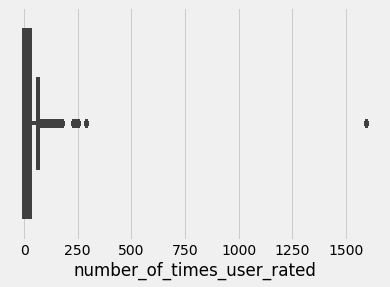

In [69]:
# lets see the distribution
sns.boxplot(x = df2.number_of_times_user_rated)

* Some preople have voted extremly high number of time even one reads one book a week no one can read more than 3000 books.
These must be organisations so we will remove anyonw who have rated more than 500 books
* Also we will only consider people who have voted minimum 5 number of books


In [70]:
# we have limitation to RAM so will consider only limited
collb_df = dataset.loc[ (dataset['number_of_times_user_rated']>= 25) & (dataset['number_of_times_user_rated'] <= 100) ].drop(columns = 'number_of_times_user_rated')

In [71]:
collb_df.head()

,User-ID,ISBN,Book-Rating
6188,37950,0553280341,8
6189,261829,0446611212,8
6190,37950,0451190556,8
6191,37950,0451176464,7
6192,261829,0061014591,8


In [72]:
collb_df.shape

(27215, 3)

In [73]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = collb_df.groupby(['ISBN', 'User-ID'])['Book-Rating'].sum().apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head()

# of unique user/item interactions: 27215


,ISBN,User-ID,Book-Rating
0,0006547834,86202,3.321928
1,0006550576,157247,2.807355
2,0006550789,76626,3.169925
3,0006550789,94347,3.000000
4,0006550789,274004,3.000000


In [74]:
# we will statify based on user and get train test split
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['User-ID'], 
                                   test_size=0.3,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 19050
# interactions on Test set: 8165


In [75]:
interactions_test_df.head()

,ISBN,User-ID,Book-Rating
18522,0553212451,86145,3.169925
17394,0452282152,240567,2.321928
26849,1566840287,127359,3.000000
10529,0425116840,68555,2.807355
3146,0312265867,193499,3.169925


In [76]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='User-ID', 
                                                          columns='ISBN', 
                                                          values='Book-Rating').fillna(0)

users_items_pivot_matrix_df.head()

ISBN,0006547834,0006550789,0007154615,0020198906,0020199600,0020427859,0020442009,0020442203,0020442300,0020442602,...,3522128001,8401491029,8420441708,8420483532,8423310353,8433969978,8445071416,8478884459,8478884955,8495618605
User-ID,,,,,,,,,,,,,,,,,,,,,
638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
users_items_pivot_matrix_df.shape

(646, 4015)

In [78]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [98]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[638, 2033, 2276, 2766, 4017, 5582, 6242, 6251, 6543, 6563]

In [99]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 30

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [100]:
users_items_pivot_matrix.shape

(646, 4015)

In [101]:
U.shape

(646, 30)

In [102]:
sigma = np.diag(sigma)
sigma.shape

(30, 30)

In [103]:
Vt.shape

(30, 4015)

In [104]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 2.97452200e-03, -1.46381667e-03,  4.97486272e-02, ...,
         4.68232841e-03,  3.77740560e-03, -3.23844239e-03],
       [-1.13666776e-02, -1.65711527e-02, -2.51747521e-02, ...,
        -1.47936252e-02, -3.91825928e-03,  3.99920546e-03],
       [-1.88590805e-02, -1.29204102e-02,  4.56143239e-02, ...,
         1.66288763e-02, -4.10309410e-04, -4.49361081e-05],
       ...,
       [ 2.15585911e-03, -5.06608386e-03,  2.07056450e-02, ...,
        -6.92958056e-04, -3.95641451e-03, -4.01640432e-03],
       [ 6.02334673e-03,  1.77041275e-02,  7.75603795e-03, ...,
        -8.13527465e-03, -7.08034371e-04, -1.21162247e-03],
       [-4.56257856e-03,  8.09497169e-03,  1.78382493e-02, ...,
        -1.88346628e-02, -8.13622795e-03, -1.64796886e-05]])

In [105]:
all_user_predicted_ratings.shape

(646, 4015)

In [106]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head()

,638,2033,2276,2766,4017,5582,6242,6251,6543,6563,...,273979,274004,274061,274301,274308,275970,276050,276231,276680,277427
ISBN,,,,,,,,,,,,,,,,,,,,,
0006547834,0.002975,-0.011367,-0.018859,0.008379,-0.035297,-0.008673,0.005713,0.023586,0.009692,0.025831,...,0.010689,0.016751,-0.011641,-0.032284,0.026873,0.020383,0.012748,0.002156,0.006023,-0.004563
0006550789,-0.001464,-0.016571,-0.012920,0.006114,0.040457,0.003808,0.017191,0.055358,0.027086,0.018965,...,0.037885,0.020188,-0.024953,-0.011636,-0.005992,0.027399,0.002708,-0.005066,0.017704,0.008095
0007154615,0.049749,-0.025175,0.045614,0.041297,-0.108772,-0.042169,0.049293,-0.087820,-0.030657,0.032720,...,0.008136,0.050751,-0.102574,-0.066237,0.060482,-0.016702,0.003186,0.020706,0.007756,0.017838
0020198906,-0.027515,0.001781,0.024204,0.008917,0.033651,-0.000219,0.010906,0.012678,0.024999,0.030199,...,0.021727,0.021713,0.064515,0.032450,0.006908,0.001739,0.006610,0.021640,-0.002045,0.045502
0020199600,0.023770,-0.021189,0.012551,0.010776,0.027068,0.006645,0.037427,-0.048874,-0.004425,-0.061436,...,0.024010,0.047096,0.032218,0.198243,-0.009122,-0.035045,0.017629,-0.003812,0.030630,0.074774


In [107]:
len(cf_preds_df.columns)

646

In [108]:
global books
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company


In [109]:
def get_items_interacted(UserID, interactions_df):
    interacted_items = interactions_df.loc[UserID]['ISBN']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [110]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df):
        self.cf_predictions_df = cf_predictions_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ISBN'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)
        recommendations_df=recommendations_df.merge(books,on='ISBN',how='inner')
        recommendations_df=recommendations_df[['ISBN','Book-Title','recStrength']]

        return recommendations_df



cf_recommender_model = CFRecommender(cf_preds_df)

In [111]:
# We will index used id so that we can speed up the process
interactions_full_indexed_df = interactions_full_df.set_index('User-ID')
interactions_train_indexed_df = interactions_train_df.set_index('User-ID')
interactions_test_indexed_df = interactions_test_df.iloc[:10000].set_index('User-ID')

In [112]:
class ModelRecommender:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, interactions_full_indexed_df)
        all_items = set(ratings_explicit['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)
        print('Recommendation for User-ID = ',person_id)
        print(person_recs_df.head(10))

        # Function to evaluate the performance of model at overall level
    def recommend_book(self, model ,userid):
        
        person_metrics = self.evaluate_model_for_user(model, userid)  
        return

model_recommender = ModelRecommender()    

In [113]:
user= 31826
model_recommender.recommend_book(cf_recommender_model,user)

Recommendation for User-ID =  31826
         ISBN                                Book-Title  recStrength
0  0451184963                                  Insomnia     1.402540
1  0451181379                      The Door to December     1.330388
2  0345384350                                  Icebound     1.222165
3  0451173317  The Waste Lands (The Dark Tower, Book 3)     1.198745
4  0451142934                             Skeleton Crew     1.142616
5  0451169522                                    Misery     1.074460
6  0156027321                                Life of Pi     1.022072
7  0345353145                                    Sphere     0.995320
8  0425121631                             Rules of Prey     0.936623
9  0425142485                              The Funhouse     0.919382


In [114]:
# The Below code is taken from almabetter course 

In [115]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, interactions_full_indexed_df)
        all_items = set(collb_df['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=item_id)    #%(2**32))

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['ISBN'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['ISBN'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['User-ID'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

In [116]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
645 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.2617268830373546, 'recall@10': 0.35590936925903244}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,User-ID
24,7,9,30,0.233333,0.300000,100906
397,6,8,30,0.200000,0.266667,37950
329,6,7,30,0.200000,0.233333,261829
437,8,12,29,0.275862,0.413793,232131
49,17,19,29,0.586207,0.655172,31826
250,7,10,29,0.241379,0.344828,23902
180,5,13,29,0.172414,0.448276,69078
509,3,4,29,0.103448,0.137931,46398
378,19,23,29,0.655172,0.793103,273113
153,11,13,28,0.392857,0.464286,76151


# Conclusion
* We get hits in the top 5 for  26 % of the times
* We get  hits in the top 10 for 36 % of the times 
* The high volume of data is limiting the model complexity
* We need to build a more complex model for the recommender system to improve the accuracy 
* The model should account for age, location and we can ask the user for interest in the genre to further narrow down the results
